# Explore peptide results and annotations

This notebook explores initial peptide results and annotations.
It's not super clean because it's an initial pass to understand what types of peptides we predicted and what types of support those predictions have.

## Notebook setup

In [1]:
library(tidyverse)
library(UpSetR)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
setwd("..")

In [3]:
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)

## Functions

In [4]:
# get FASTA sequence names from a FASTA file as a data frame
read_fasta_names <- function(file_path) {
  lines <- read_lines(file_path)
  
  # Filter lines that start with '>'
  filtered_lines <- lines[str_detect(lines, "^>")]
  
  tibble(peptide_name = filtered_lines) %>%
    mutate(peptide_name = gsub(" .*", "", peptide_name),
           peptide_name = gsub("^>", "", peptide_name))
}

## Read in peptide data and metadata

In [5]:
evidence_of_itch_suppression_species <- c("Sarcoptes scabiei",
                                          "Psoroptes ovis",
                                          "Amblyomma americanum",
                                          "Amblyomma sculptum",
                                          "Dermacentor andersoni",
                                          "Dermacentor silvarum",
                                          "Dermacentor variabilis",
                                          "Haemaphysalis longicornis",
                                          "Hyalomma asiaticum",
                                          "Ixodes persulcatus",
                                          "Ixodes ricinus",
                                          "Ixodes scapularis",
                                          "Rhipicephalus microplus",
                                          "Rhipicephalus sanguineus")

In [6]:
list.files("inputs")

[1] "2024-06-26-top-positive-significant-clusters-orthogroups-annotations.tsv.gz"
[2] "2024-06-26-top-positive-significant-clusters-orthogroups-proteins.fasta.gz" 
[3] "2024-11-25-top-positive-significant-clusters-orthogroups-annotations.tsv.gz"
[4] "2024-11-25-top-positive-significant-clusters-orthogroups-proteins.fasta.gz" 
[5] "antipruritic_peptides"                                                      
[6] "autopeptideml_antiinflammatory"                                             
[7] "tsa_sg_peptides.faa.gz"

In [7]:
predictions <- read_tsv("outputs/ToT_20241125/predictions/peptide_predictions.tsv", show_col_types = F) %>%
  mutate(peptide_length = nchar(protein_sequence),
         locus_tag = gsub("_start.*", "", peptide_id)) %>%
  mutate(peptide_class = ifelse(is.na(peptide_class), "sORF", peptide_class))


metadata <- read_tsv("inputs/2024-11-25-top-positive-significant-clusters-orthogroups-annotations.tsv.gz", show_col_types = F)



predictions <- left_join(predictions, metadata, by = "locus_tag") %>%
  mutate(species = gsub("-", " ", species)) %>%
  mutate(evidence_of_itch_suppression = ifelse(species %in% evidence_of_itch_suppression_species, 
                                               "evidence of itch suppression", 
                                               "no evidence of itch suppression"))

## Remove propeptides

DeepPeptide predict peptides and propeptides.
The tool uses the [UniProt definition of propeptide](https://www.uniprot.org/help/propep).
> A **Propeptide** is a part of a protein that is cleaved during maturation or activation of the protein. It is generally understood not to have an independent function.
A **Peptide** is proteolytically cleaved and has a well-defined biological activity.

Given this, we remove propeptide predictions as DeepPeptide would predict that these are not biologically active after being cleaved from their precursor protein.

In [8]:
table(predictions$peptide_class)

predictions <- predictions %>%
  filter(peptide_class != "Propeptide")


BACTERIAL_HEAD_TO_TAIL_CYCLIZED            CLASS_I_LANTIPEPTIDE 
                              1                               1 
          CLASS_II_LANTIPEPTIDE                   LASSO_PEPTIDE 
                              3                               6 
                        Peptide                      Propeptide 
                            110                             385 
                           sORF 
                            235 

In [9]:
nrow(predictions)
length(unique(predictions$protein_sequence))

[1] 356

[1] 353

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


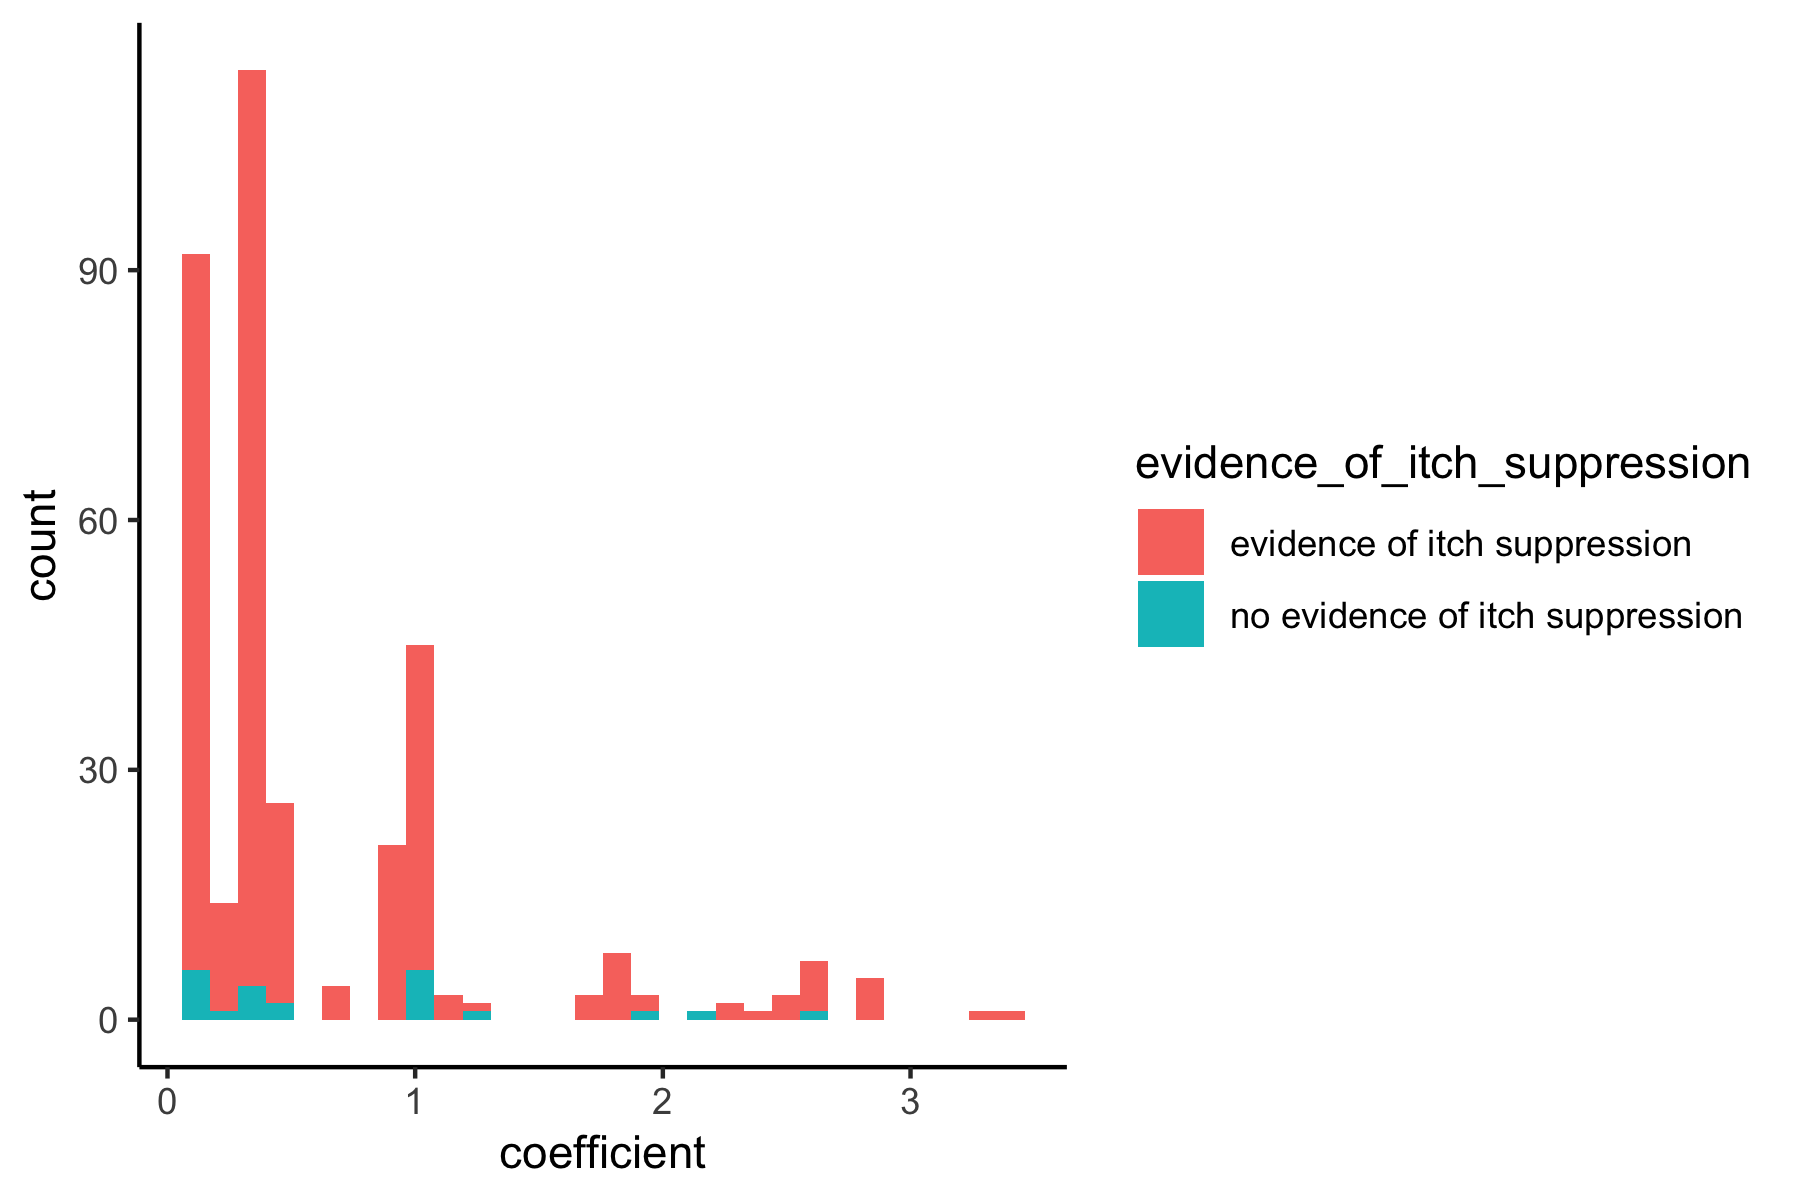

In [10]:
ggplot(predictions, aes(x = coefficient, fill = evidence_of_itch_suppression)) +
  theme_classic() +
  geom_histogram()

## TSA salivary gland transcriptomes

In [11]:
tsa <- read_tsv("outputs/analysis/compare_tsa_sg/tsa_sg_peptides_blastp_matches.tsv", show_col_types = FALSE) %>%
  # select only one blast hit for each query peptide
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  filter(qseqid %in% predictions$peptide_id)

In [12]:
nrow(tsa)

[1] 151

## peptigate results

In [13]:
peptigate <- read_tsv("outputs/ToT_20241125/predictions/peptide_annotations.tsv", show_col_types = F)

peptipedia <- peptigate %>%
  select(peptide_id, sequence, starts_with("peptipedia")) %>%
  filter(!is.na(peptipedia_blast_sseqid)) %>%
  filter(peptide_id %in% predictions$peptide_id)

In [14]:
nrow(peptipedia)

[1] 50

## Known anti-pruritic peptide comparison

In [15]:
# read in BLASTp results for peptigate predictions vs. 5 known antipruritic peptides
antip <- read_tsv("outputs/analysis/predict_antipruritic.tsv", show_col_types = FALSE) %>%
  # select only one blast hit for each query peptide
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup()

# get anti-pruritic peptide names and types (these are the peptides that made up the BLAST database with known anti-pruritic activity)
antip_names <- Sys.glob("inputs/antipruritic_peptides/*faa.gz") %>%
  set_names() %>%
  map_dfr(read_fasta_names, .id = "antipruritic_peptide") %>%
  mutate(antipruritic_peptide = gsub(".faa.gz", "", basename(antipruritic_peptide)))

antip <- antip %>%
  # join with antipruritic peptide names so its more interpretable
  left_join(antip_names, by = c("sseqid" = "peptide_name")) %>%
  filter(qseqid %in% predictions$peptide_id)

In [16]:
nrow(antip)

[1] 0

## Human hits

In [17]:
# read in BLASTp results for peptigate predictions vs. human peptides in human peptide atlas
human <- read_tsv("outputs/analysis/compare_human/humanpeptideatlas_blastp_matches.tsv", show_col_types = FALSE) %>%
  # select only one blast hit for each query peptide
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  filter(qseqid %in% predictions$peptide_id)

nrow(human)

[1] 8

## MMSeqs2 clusters

In [18]:
clustering <- read_tsv("outputs/analysis/clustering/all_peptides_0.8_cluster.tsv",
                       show_col_types = FALSE,
                       col_names = c("mmseqs2_representative_sequence",
                                     "mmseqs2_cluster_member")) %>%
  filter(mmseqs2_cluster_member %in% predictions$peptide_id)

In [19]:
representatives_of_clusters_with_more_than_one_sequence <- clustering %>%
  group_by(mmseqs2_representative_sequence) %>%
  tally() %>%
  ungroup() %>%
  filter(n > 1)

clusters_with_more_than_one_sequence <- clustering %>%
  filter(mmseqs2_representative_sequence %in% representatives_of_clusters_with_more_than_one_sequence$mmseqs2_representative_sequence)

nrow(clusters_with_more_than_one_sequence)

[1] 104

## Filter down to peptides that have any supporting evidence that they are real
  * other ticks on a tree peptides (clustered by mmseqs2 @ 80% identity)
  * other ticks salivary gland peptides (predicted by peptigate from tick TSA transcriptomes)
  * peptipedia hits (reported by peptigate)
  * human hits
  * itch peptide hits

In [20]:
any_supporting_evidence_that_peptide_is_real <- unique(c(peptipedia$peptide_id, antip$qseqid, tsa$qseqid,
                                                         clusters_with_more_than_one_sequence$mmseqs2_cluster_member, 
                                                         human$qseqid))

length(any_supporting_evidence_that_peptide_is_real)

[1] 203

In [21]:
evidence_that_peptide_is_real_upset_df <- fromList(list(peptipedia = peptipedia$peptide_id,
                                                        antipruritic_blast = antip$qseqid,
                                                        tick_sg_txome = tsa$qseqid,
                                                        mmseqs2_clusters = clusters_with_more_than_one_sequence$mmseqs2_cluster_member,
                                                        human_peptide_atlas = human$qseqid))

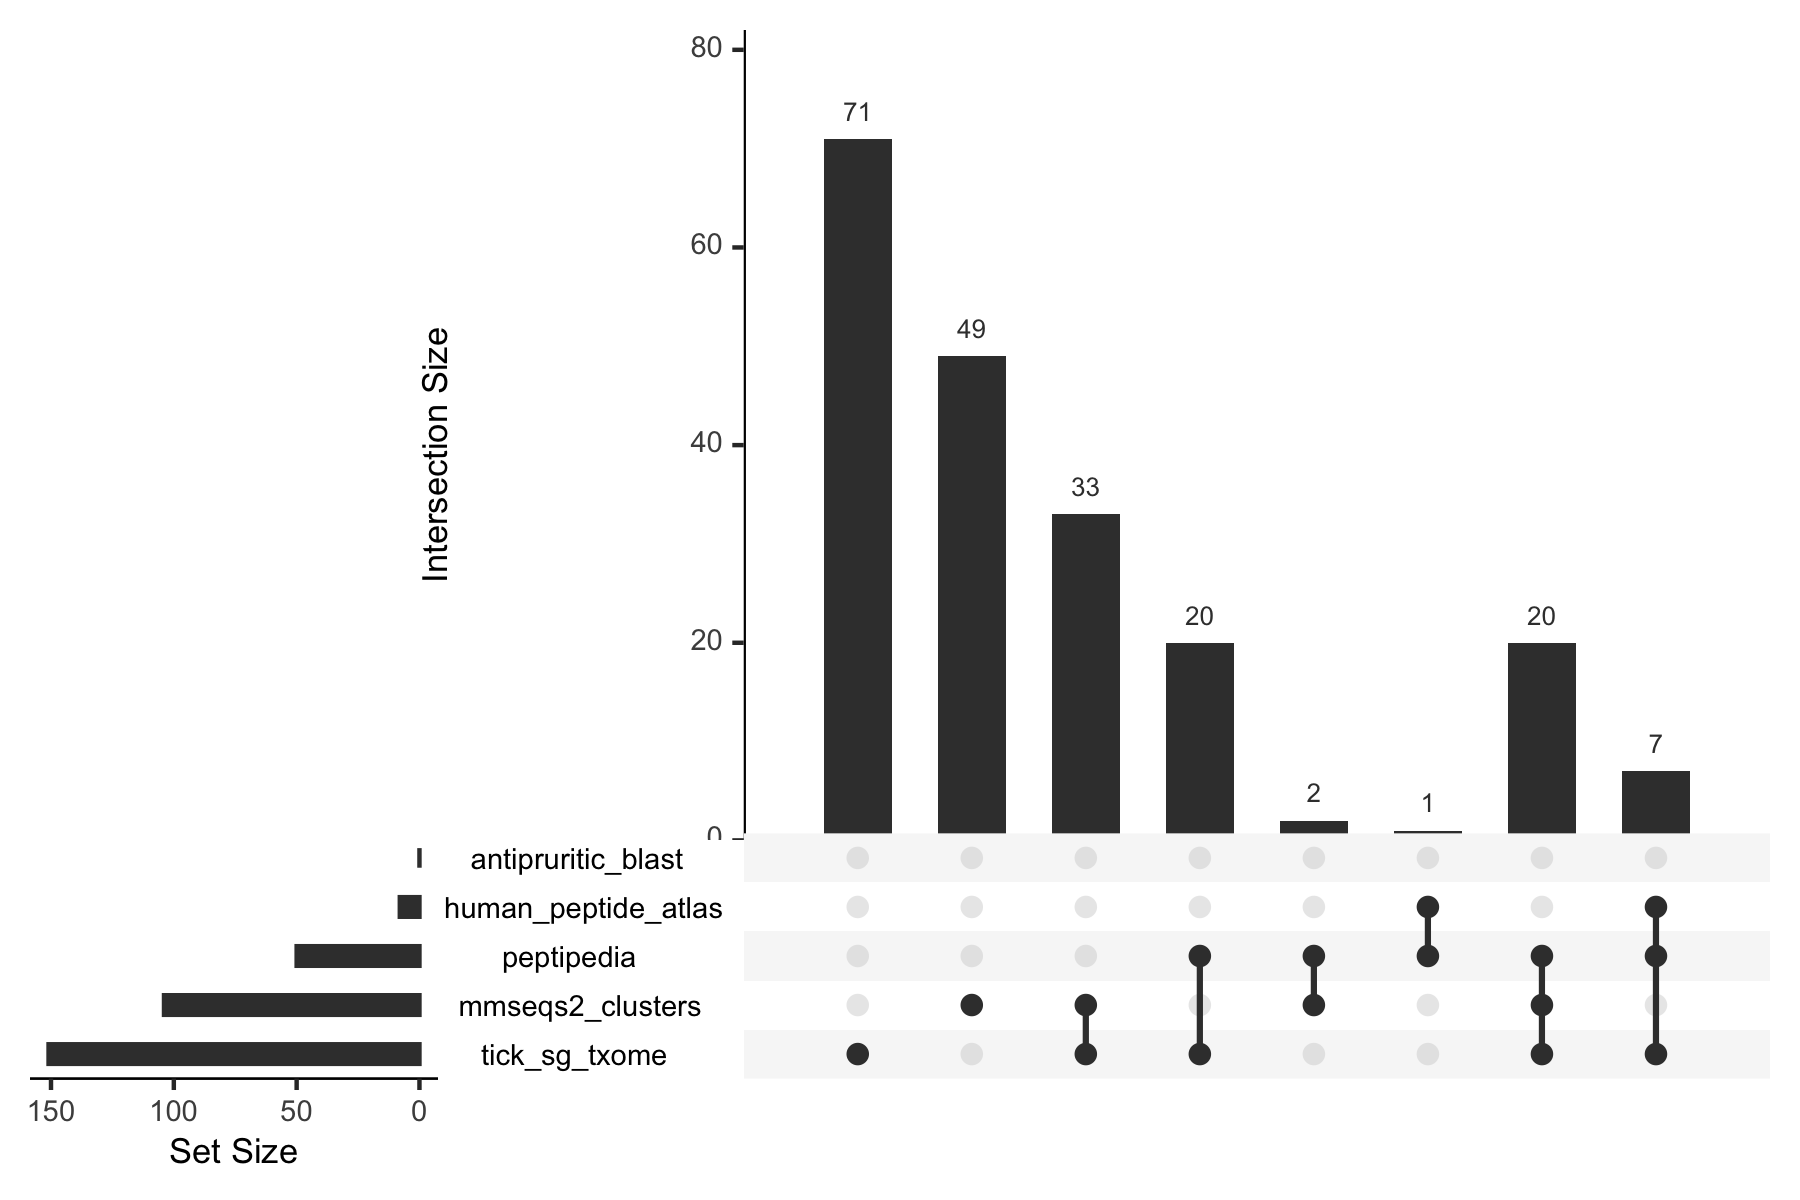

In [22]:
UpSetR::upset(evidence_that_peptide_is_real_upset_df)

In [23]:
length(any_supporting_evidence_that_peptide_is_real)/nrow(predictions)

[1] 0.5702247

In [24]:
predictions_with_support <- predictions %>%
  filter(peptide_id %in% any_supporting_evidence_that_peptide_is_real)

In [25]:
length(unique(predictions_with_support$protein_sequence)) / length(unique(predictions$protein_sequence))

[1] 0.5665722

**57% of peptide sequences had support in another data source.**

## just filter to things in the TSA so we know that it's in the saliva?

In [26]:
predictions_with_support_and_tsa <- predictions_with_support %>%
  filter(peptide_id %in% tsa$qseqid)

In [27]:
nrow(predictions_with_support_and_tsa)

[1] 151

In [28]:
table(predictions_with_support_and_tsa$orthogroup)


OG0000079 OG0000143 OG0000189 OG0000194 OG0000305 OG0000385 OG0000746 OG0000880 
       28         5        15        10         2         2         2        30 
OG0001663 OG0001774 OG0002194 OG0008102 OG0008888 OG0009053 OG0011284 OG0015609 
        4        34         1        13         1         1         1         2 

## are these peptides anti-inflammatory?

In [29]:
antiinflammatory <- read_tsv("outputs/analysis/predict_antiinflammatory/autopeptideml_antiinflammatory_predictions.tsv", show_col_types = F)

In [30]:
tmp <- left_join(predictions_with_support_and_tsa, antiinflammatory, by = "peptide_id")

## Target orthogroups that have a mix of proteins from species with and without evidence of anti-itch

From Austin in slack:
> As for mixed orthogroups. Yes, I would absolutely expect these orthogroups to possess proteins/peptides present in both itch suppressing and non-itch suppressing species. Below is a very long winded explanation of why, with hopefully some description that can provide you with a bit more intuition about what’s going on.
> * These tests are not looking for pure presence/absence patterns (i.e. completely absent in non-suppressing and present in suppressing species) - they are looking for gross patterns.
> * At the level of profile clusters, I took the mean counts of different event types, e.g. speciation events in the gene family (i.e. any bifurcation in the gene family tree) within itch suppressing species, and within non-itch suppressing species.
> * I then carried out logistic regressions asking whether the mean event counts predicted itch suppression (binary, 0/1).
>    * So long as the counts significantly differed between itch suppressing and non-itch suppressing species (and the coefficients are sufficiently large so as to be retained, depending on how you filtered), they will be included in your set of “itch suppression-associated” clusters
> * Within profile cluster, I then conducted logistic regressions for each gene family individual, this time regressing the event counts for each species, against the response - the binary itch suppression trait.
>    * One key bit is that this time i used a phylogenetic logistic regression that accounts for the evolutionary non-independence.
>    * That will ultimately mean that in a hypothetical scenario where all ticks have one or more gene copy of something, but no other species do (including other non-tick itch suppressing species), this is unlikely (or less likely) to lead to a significant association.
>    * This is because although we have a bunch of the ticks in the dataset, they are effectively evolutionary pseudoreplicates, as that gene only is associated with a single evolutionary “origin” or incidence of itch suppression.
>    * The association between that gene and itch suppression is confounded with the association between that gene and… ticks. And all other traits that are unique to them, independent of itch suppression. 
> * This is all to say… These are just statistical associations between gene family event counts in profile clusters or gene families within them and itch suppression.
>    * Because they are associations between these different event types and not just gene presence/absence, they will include cases where the gene is typically absent in one group and present in the other, as well as cases where it’s present in both, but the “magnitude” or frequency of event counts differs.
>
> As final thought: I think one thing that would be particularly useful to consider in your filtering (and this relates to some of the final points I made above regarding evolutionary pseudoreplication) is to not only consider those gene families where peptides are present in multiple ticks, but multiple ticks as well as other non-tick itch suppressing species. To be fair, the statistical tests should already be “prioritizing” these

In [31]:
metadata <- read_tsv("inputs/2024-11-25-top-positive-significant-clusters-orthogroups-annotations.tsv.gz", show_col_types = F)

metadata <- metadata %>%
  mutate(species = gsub("-", " ", species)) %>%
  mutate(evidence_of_itch_suppression = ifelse(species %in% evidence_of_itch_suppression_species, 
                                               "evidence of itch suppression", 
                                               "no evidence of itch suppression"))

In [32]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] UpSetR_1.4.0    lubridate_1.9.4 forcats_1.0.0   stringr_1.5.1  
 [5] dplyr_1.1.4     purrr_1.0.2     readr_2.1.5     tidyr_1.3.1    
 [9] tibble_3.2.1    ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] bit_4.5.0.1       gtable_0.3.6      jsonlite_1.8.9    compiler_4.3.3   
 [5] crayon_1.5.3      Rcpp_1.0.13-1     tidyselect_1.2.1  IRdisplay_1.1    
 [9] parallel_4.3.3    gridExtra_2.3     scales_1.3.0      uuid_1.2-1       
[13] fastmap_1.2.0  